In [56]:
from matplotlib.ticker import PercentFormatter

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import numpy as np

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

In [28]:
# set up via Google Sheets API
import os
from dotenv import load_dotenv
import gspread

load_dotenv()
sheet_id = os.environ['sheet_id']

gc = gspread.service_account(filename="/Users/quinny/repos/mdagent-key.json")
sheets = gc.open_by_key(sheet_id)

# model performance & step analysis

In [94]:
worksheet = sheets.worksheet("k1 results")

In [108]:
result = worksheet.get("A229:L238")
df = pd.DataFrame(result[2:], columns=result[1]) # ignore first row, trivial
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df = df.iloc[:, 5:] # remove first 5 columns
df.head()

,completed without runtime error,all steps attempted,Completed wo hallucination,Logic makes sense,answer is logical,avg % steps completed
Model,,,,,,
gpt-3.5-turbo,0.8800,0.3600,0.6800,0.5200,0.3200,0.5966
gpt-4-1106-preview,0.8400,0.4800,0.7600,0.4800,0.3200,0.6177
gpt-4-turbo,0.8000,0.4400,0.8400,0.5200,0.4400,0.5847
gpt-4o-2024-08-06,0.8800,0.9200,1.0000,0.8800,0.7200,0.9234
Claude 3 Opus,0.8636,0.6818,0.9091,0.9545,0.6818,0.8236


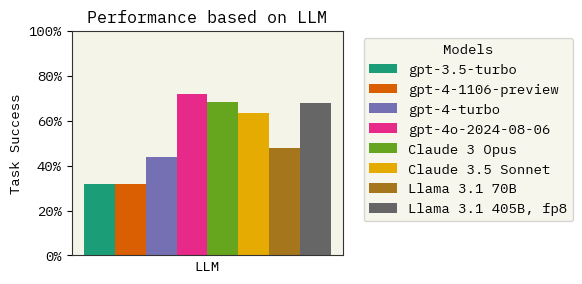

In [117]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#plt.bar(df.index, df['answer is logical '], color=colors)
for i, label in enumerate(df.index):
    plt.bar(label, df.loc[label, 'answer is logical '], color=colors[i % len(colors)], label=label, width=1.0)

plt.title('Performance based on LLM')
plt.xlabel('LLM')
plt.xticks([])
plt.ylabel('Task Success')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')

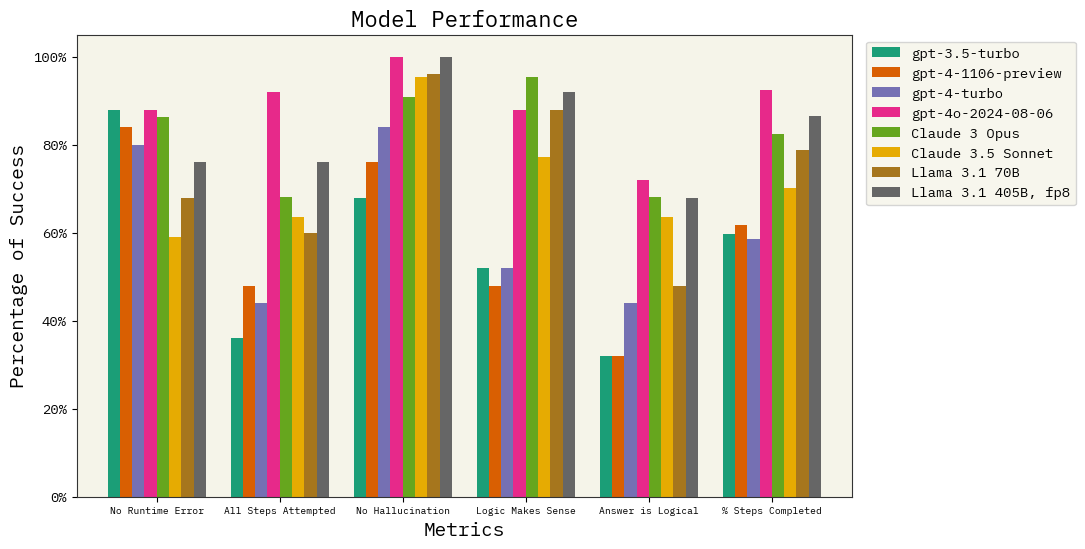

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = [
   "No Runtime Error",  "All Steps Attempted",  
     "No Hallucination",  "Logic Makes Sense", "Answer is Logical",
     "% Steps Completed"
]
df_transposed = df.T

ax = df_transposed.plot(kind='bar', width=0.8, ax=ax)
plt.title("Model Performance", size=16)
plt.xlabel('Metrics', size=14)
plt.ylabel('Percentage of Success', size=14)
ax.set_xticklabels(metrics, rotation=0, size=7)
plt.ylim(0, 1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.legend()

In [ ]:
# result = worksheet.get("A229:L238")
# df = pd.DataFrame(result[2:], columns=result[1]) # ignore first row, trivial
# df.set_index(df.columns[0], inplace=True)
# df = df.apply(pd.to_numeric)
# df = df.iloc[:, 5:] # remove first 5 columns
# df.head()

# result = worksheet.get("F65:L68")
# df = pd.DataFrame(result[1:], columns=result[0])
# df.set_index(df.columns[0], inplace=True)
# df = df.apply(pd.to_numeric)
# df.head()

# comparison analysis

In [29]:
worksheet = sheets.worksheet("python code")

In [68]:
result = worksheet.get("F65:L68")
df = pd.DataFrame(result[1:], columns=result[0])
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df.head()


,completed without runtime error,all steps attempted,Completed wo hallucination,logic makes sense,answer is logical,% step completed
LLM Framework,,,,,,
direct LLM,0.3600,0.8400,1.0000,0.2800,0.2800,0.4986
ReAct with Python REPL,0.8800,0.5200,1.0000,0.5200,0.2400,0.5109
MDAgent,0.8800,0.9200,1.0000,0.8800,0.7200,0.9234


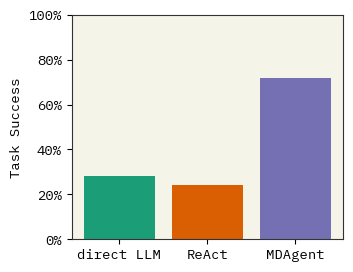

In [81]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.bar(df.index, df['answer is logical '], color=colors)
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Task Success')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))


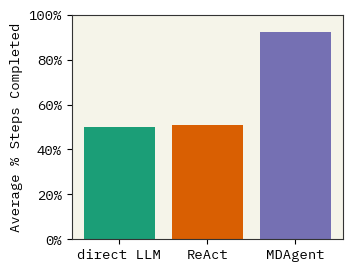

In [79]:
data = df['% step completed']

plt.bar(df.index, data, color=colors)
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Average % Steps Completed')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

In [83]:
result = worksheet.get("D72:N75")
df = pd.DataFrame(result[1:], columns=result[0])
df.set_index(df.columns[0], inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
direct LLM,1.0,0.625,0.4444,0.5000,0.7,0.2500,0.2857,0.1250,0.5556,0.15
ReAct with Python REPL,1.0,0.500,0.4444,0.1667,0.5,0.5833,0.6429,0.9375,0.0556,0.25
MDAgent,1.0,1.000,1.0000,0.8333,1.0,0.8333,0.7143,1.0000,0.9444,0.80


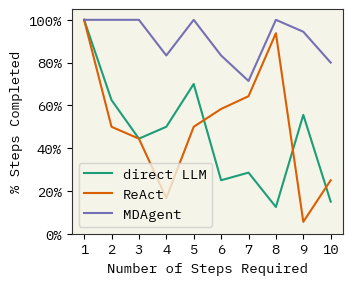

In [93]:
df.rename(index={"ReAct with Python REPL": "ReAct"}, inplace=True)

plt.plot(df.columns, df.loc['direct LLM'], label='direct LLM')
plt.plot(df.columns, df.loc['ReAct'], label='ReAct')
plt.plot(df.columns, df.loc['MDAgent'], label='MDAgent')
plt.legend()
plt.ylabel('% Steps Completed')
plt.xlabel('Number of Steps Required')
plt.ylim(0,1.05)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
